In [70]:
import numpy as np
import matplotlib.pyplot as plt
from Rocket import Rocket
from Dynamics import Dynamics
from Plot3D import Plot3D
from MPC import MPC
from Sliding import Sliding
from Quat import Quat

import time
import pylab as pl
from IPython import display

#np.set_printoptions(precision=3,suppress=True)

In [71]:
#https://www.spacex.com/vehicles/falcon-9/

falcon = Rocket("Falcon 9")
falcon.mass = 100 #kg
falcon.height = 7 #m
falcon.radius = 0.37/2 #m
falcon.max_thrust = 10 #N
falcon.cg_thrust_length = 2 #m
falcon.cg_cp_length = 1.5 #m
falcon.Cd = 10000.82

falcon.load()
dynamics = Dynamics(falcon)
mpc = MPC(falcon)

In [72]:
""" falcon.input(0.05,0.01,1*np.pi/2)
for j in range(100):
        dynamics.update(0.1)

plot3d = Plot3D(falcon, dynamics.states)
plot3d.set(10,5)
plot3d.plot()
plot3d.attitude()
plot3d.origin()
print("Plot?") """

' falcon.input(0.05,0.01,1*np.pi/2)\nfor j in range(100):\n        dynamics.update(0.1)\n\nplot3d = Plot3D(falcon, dynamics.states)\nplot3d.set(10,5)\nplot3d.plot()\nplot3d.attitude()\nplot3d.origin()\nprint("Plot?") '

In [73]:
class Attitude(Sliding):
    def __init__(self,rocket):
        self.rocket = rocket
        eta = np.diag([1,1,1])
        lam = 2
        phi = 10
        alpha = 2 #Hz

        B = rocket.inertia/rocket.inertia[0,0]
        B2 = np.linalg.inv(B)
        A = lambda w: B2 @ np.cross(w,rocket.inertia@w,axis=0)
        
        
        super().__init__(eta,lam,phi,alpha,A,B)

    def control(self,state):
        theta = Quat.eulerAngles(state[6:10])
        theta2 = np.array([[theta[0],theta[1],theta[2]]]).T
        print("theta",theta2)
        w = np.array([state[10:13]]).T
        print("w",w)
        c = self.input(theta2,w)
        print("c",c)

    

        print("theta",theta2)
        print("w",w)
        print("c",c)
        import time
        time.sleep(1)
        return [0,c[1,0]/self.rocket.cg_thrust_length*100,-c[2,0]/self.rocket.cg_thrust_length*100]
    
attitude = Attitude(falcon)

attitude.ref = np.array([[0.1,0.1,0]]).T
x0 = [0,0,0,0,0,0,0]


In [74]:
from scipy.integrate import solve_ivp
N = 1000
tf = 20
t_eval = np.linspace(0,tf,N+2)
B2 = np.linalg.inv(falcon.inertia/falcon.inertia[0,0])


for i in range(N):
    theta_x,theta_y,theta_z,wx,wy,wz,phi= x0
    q = np.array([[theta_x,theta_y,theta_z]]).T
    dq = np.array([[wx,wy,wz]]).T
    u = attitude.input(q,dq)

    print(u)

    def ode(t,state):
        theta_x,theta_y,theta_z,wx,wy,wz,phi= state
        attitude.phi = 2

        q = np.array([[theta_x,theta_y,theta_z]]).T
        dq = np.array([[wx,wy,wz]]).T

        th_dot = u #B2 @ u -B2 @ np.cross(dq,(falcon.inertia/falcon.inertia[0,0])@dq,axis=0)
        
        phi_dot = 0
        return [wx,wy,wz,th_dot[0,0],th_dot[1,0],th_dot[2,0],phi_dot]

    sol = solve_ivp(ode,[0,tf/N],x0)
    x0 = sol.y[:,-1]



[[0.06]
 [0.06]
 [0.  ]]
[[0.274164]
 [0.274164]
 [0.      ]]
[[0.15603698]
 [0.15603698]
 [0.        ]]
[[8.84464605e-02]
 [8.84464605e-02]
 [3.95087230e-13]]
[[ 4.97731734e-02]
 [ 4.97731734e-02]
 [-4.05946117e-11]]
[[2.76464680e-02]
 [2.76464680e-02]
 [4.12953666e-09]]
[[ 1.49877946e-02]
 [ 1.49877937e-02]
 [-4.20161770e-07]]
[[7.74672389e-03]
 [7.74681509e-03]
 [4.27496497e-05]]
[[ 0.00361044]
 [ 0.00360105]
 [-0.00434959]]
[[0.00075848]
 [0.00171863]
 [0.44255231]]
[[  0.04885526]
 [ -0.0490148 ]
 [-45.02779098]]
[[  -4.62783662]
 [   5.32893771]
 [4581.38372213]]
[[   4402.86390343]
 [   2872.46006163]
 [-433738.32896837]]
[[-2.00942042e+08]
 [ 3.07086976e+08]
 [ 4.09666281e+07]]
[[ 2.02475562e+15]
 [ 1.32485513e+15]
 [-3.86916829e+09]]
[[-8.25017081e+23]
 [ 1.26086044e+24]
 [ 3.65430558e+11]]
[[ 7.41564118e+34]
 [ 4.85226630e+34]
 [-3.45137461e+13]]
[[-2.69533999e+47]
 [ 4.11924511e+47]
 [ 3.25971281e+15]]
[[ 2.16109472e+62]
 [ 1.41406614e+62]
 [-3.07869438e+17]]
[[-7.00669365e+

KeyboardInterrupt: 

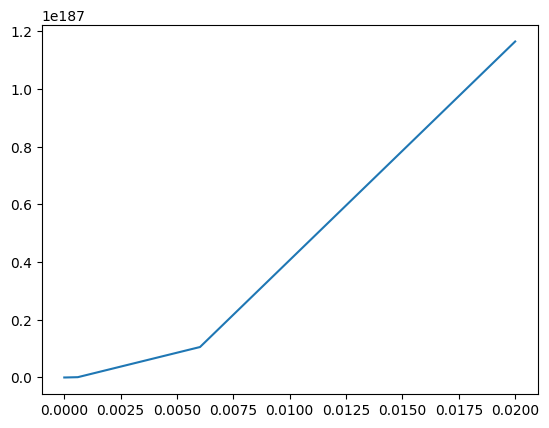

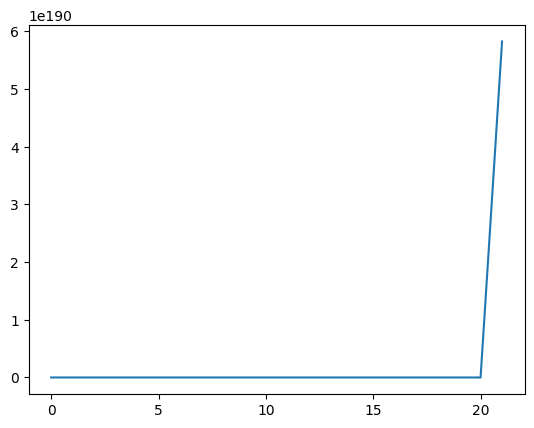

In [75]:
plt.plot(sol.t,sol.y[0])

plt.figure()

plt.plot(attitude.inputs[0,:])